In [34]:
import numpy as np
import pandas as pd
import os
import random
import keras_tuner as kt
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
from keras_tuner import Hyperband
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, f1_score
import seaborn as sns
from tensorflow.keras.layers import LSTM, Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Reshape, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
DATA_PATH = './data/original'
RNN_IMAGE_RESULTS = './results/rnn/images'
RNN_HISTORY_RESULTS = './results/rnn/history'
RNN_REPORT_RESULTS = './results/rnn/reports'
RNN_MODEL_RESULTS = './results/rnn/models'

TRAIN_DIRECTORY = 'train'
VALIDATION_DIRECTORY = 'val'
TEST_DIRECTORY = 'test'

SUB_DIRECTORIES = [TRAIN_DIRECTORY, TEST_DIRECTORY, VALIDATION_DIRECTORY]
CATEGORY_DIRECTORIES = ['Actinic keratoses', 'Basal cell carcinoma', 'Benign keratosis-like lesions', 'Chickenpox', 'Cowpox', 'Dermatofibroma', 'Healthy', 'HFMD', 'Measles', 'Melanocytic nevi', 'Melanoma', 'Monkeypox', 'Squamous cell carcinoma', 'Vascular lesions']

In [3]:
def count_images(dir_name):
    for dataset_type in SUB_DIRECTORIES:
        total = 0
        dir_type = os.path.join(dir_name, dataset_type)
        print(f"============ {dataset_type} dataset ===========")
        for category in os.listdir(dir_type):
            category_path = os.path.join(dir_type, category)
            if not os.path.isdir(category_path):
                continue
            images = [img for img in os.listdir(category_path) if img.endswith(('jpg','jpeg'))]
            print(f"Number of images in {category_path.split('/')[-1]}: {len(images)}")
            total += len(images)
        print(f"Total image count: {total}")
        print("")

In [4]:
count_images(DATA_PATH)

============ train dataset ===========
Number of images in Benign keratosis-like lesions: 1000
Number of images in Cowpox: 792
Number of images in Healthy: 1000
Number of images in Actinic keratoses: 693
Number of images in Melanoma: 1000
Number of images in HFMD: 1000
Number of images in Melanocytic nevi: 1000
Number of images in Measles: 660
Number of images in Chickenpox: 900
Number of images in Basal cell carcinoma: 1000
Number of images in Squamous cell carcinoma: 502
Number of images in Monkeypox: 1000
Number of images in Dermatofibroma: 191
Number of images in Vascular lesions: 202
Total image count: 10940

============ test dataset ===========
Number of images in Benign keratosis-like lesions: 100
Number of images in Cowpox: 99
Number of images in Healthy: 100
Number of images in Actinic keratoses: 88
Number of images in Melanoma: 100
Number of images in HFMD: 100
Number of images in Melanocytic nevi: 100
Number of images in Measles: 83
Number of images in Chickenpox: 100
Numbe

In [5]:
def load_images_to_df(base_path, dataset_type):
    path = os.path.join(base_path, dataset_type)
    image_dir = Path(path)

    file_paths = list(image_dir.glob(r'**/*.jpg'))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_paths))

    file_paths = pd.Series(file_paths, name='Path').astype(str)
    labels = pd.Series(labels, name='Label')

    image_df = pd.concat([file_paths, labels], axis=1)

    samples = []
    for record in image_df['Label'].unique():
        samples.append(image_df[image_df['Label']==record])
    image_df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=42).reset_index(drop=True)

    return image_df

In [6]:
df_train = load_images_to_df(DATA_PATH, TRAIN_DIRECTORY)
df_train.head(10)

,Path,Label
0,data/original/train/Benign keratosis-like lesi...,Benign keratosis-like lesions
1,data/original/train/Healthy/HEALTHY_59_02_8.jpg,Healthy
2,data/original/train/Melanocytic nevi/ISIC_0010...,Melanocytic nevi
3,data/original/train/Healthy/HEALTHY_26_02_8.jpg,Healthy
4,data/original/train/Monkeypox/MKP_142_06_9.jpg,Monkeypox
5,data/original/train/Vascular lesions/ISIC_0027...,Vascular lesions
6,data/original/train/Melanocytic nevi/ISIC_0011...,Melanocytic nevi
7,data/original/train/Healthy/HEALTHY_58_01_ORIG...,Healthy
8,data/original/train/Cowpox/CWP_19_01_13.jpg,Cowpox
9,data/original/train/Benign keratosis-like lesi...,Benign keratosis-like lesions


In [7]:
df_val = load_images_to_df(DATA_PATH, VALIDATION_DIRECTORY)
df_val.head(10)

,Path,Label
0,data/original/val/Cowpox/CWP_33_06_10.jpg,Cowpox
1,data/original/val/Chickenpox/CHP_53_01_ORIGINA...,Chickenpox
2,data/original/val/Benign keratosis-like lesion...,Benign keratosis-like lesions
3,data/original/val/Chickenpox/CHP_03_01_12.jpg,Chickenpox
4,data/original/val/Melanocytic nevi/ISIC_001057...,Melanocytic nevi
5,data/original/val/Measles/MSL_44_01_9.jpg,Measles
6,data/original/val/Measles/MSL_37_01_3.jpg,Measles
7,data/original/val/Melanocytic nevi/ISIC_000176...,Melanocytic nevi
8,data/original/val/Benign keratosis-like lesion...,Benign keratosis-like lesions
9,data/original/val/HFMD/HFMD_123_01.jpg,HFMD


In [8]:
df_test = load_images_to_df(DATA_PATH, TEST_DIRECTORY)
df_test.head(10)

,Path,Label
0,data/original/test/Actinic keratoses/ISIC_0071...,Actinic keratoses
1,data/original/test/Basal cell carcinoma/ISIC_0...,Basal cell carcinoma
2,data/original/test/Vascular lesions/ISIC_00707...,Vascular lesions
3,data/original/test/Benign keratosis-like lesio...,Benign keratosis-like lesions
4,data/original/test/Squamous cell carcinoma/ISI...,Squamous cell carcinoma
5,data/original/test/Melanoma/ISIC_0014559_downs...,Melanoma
6,data/original/test/Monkeypox/MKP_126_01_ORIGIN...,Monkeypox
7,data/original/test/Basal cell carcinoma/ISIC_0...,Basal cell carcinoma
8,data/original/test/Actinic keratoses/ISIC_0063...,Actinic keratoses
9,data/original/test/Actinic keratoses/ISIC_0072...,Actinic keratoses


In [9]:
def pie_plot_from_df(df, title):
    pie = df["Label"].value_counts()
    pie.plot(kind="pie", autopct="%1.2f%%")
    plt.ylabel("")
    plt.xlabel(title)
    plt.show()

In [10]:
def show_images_from_df(df, nrows, ncols):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,8), subplot_kw={"xticks":[], "yticks":[]})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(df.Path[i], -1))
        ax.set_title(df.Label[i])
    plt.tight_layout()
    plt.show()

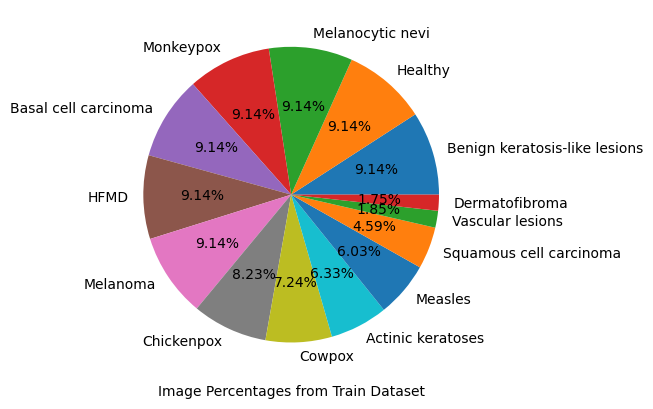

In [11]:
pie_plot_from_df(df_train, "Image Percentages from Train Dataset")

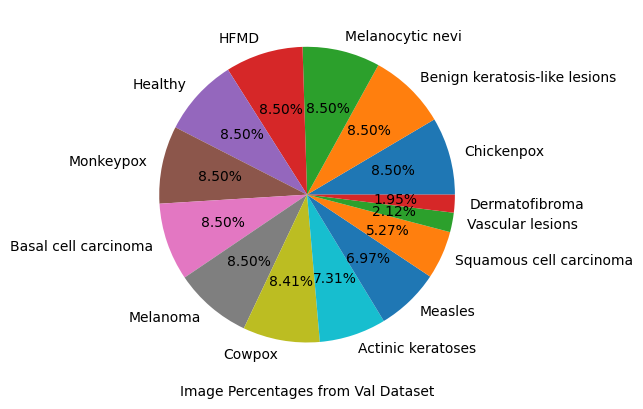

In [12]:
pie_plot_from_df(df_val, "Image Percentages from Val Dataset")

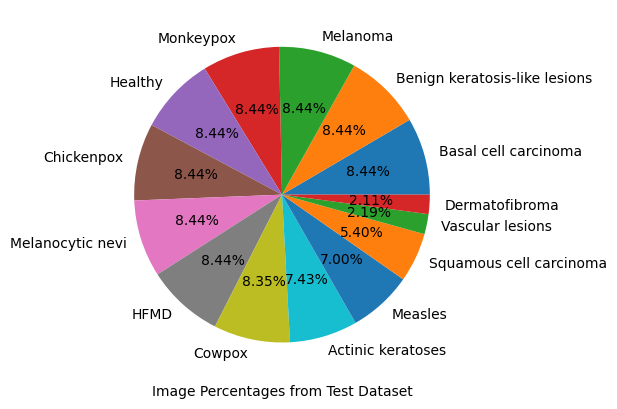

In [13]:
pie_plot_from_df(df_test, "Image Percentages from Test Dataset")

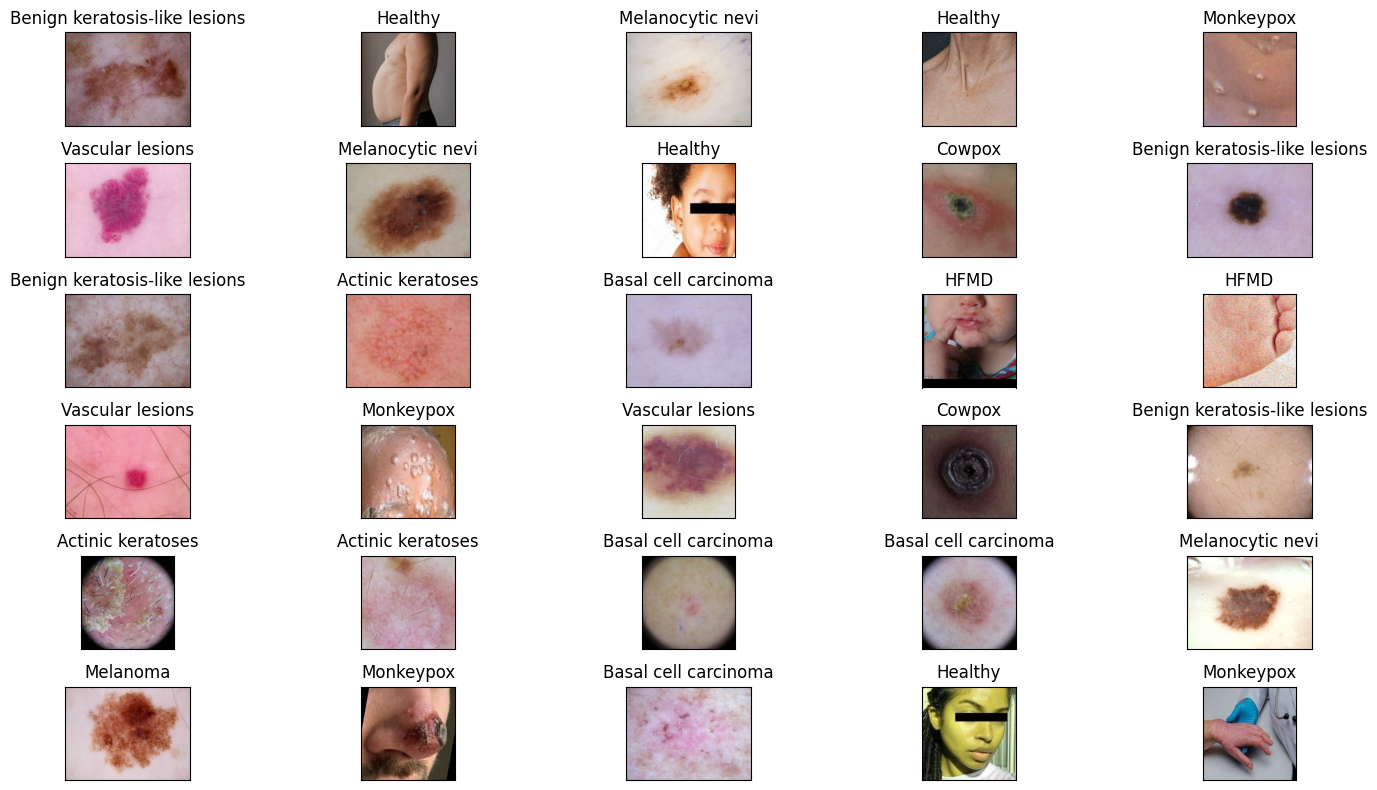

In [14]:
show_images_from_df(df_train, 6, 5)

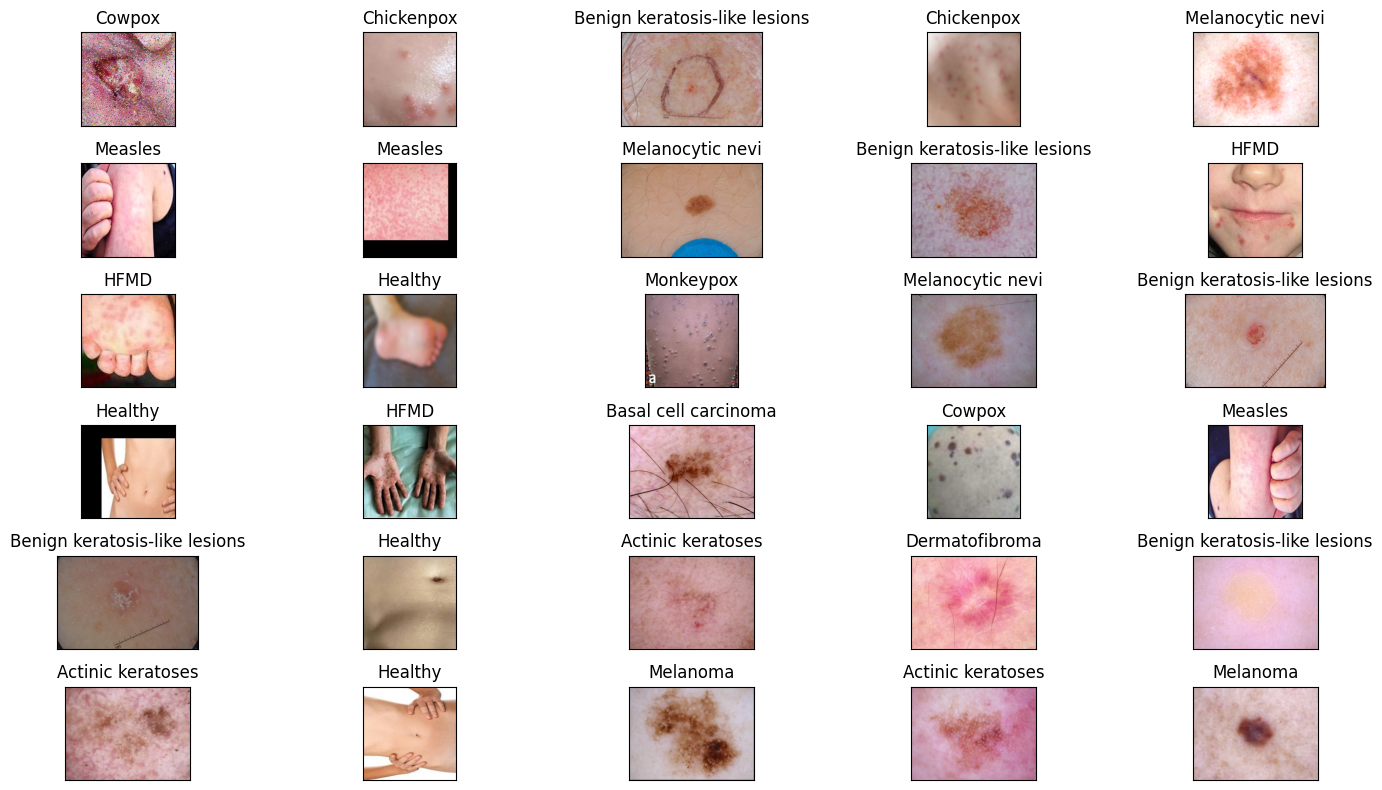

In [15]:
show_images_from_df(df_val, 6, 5)

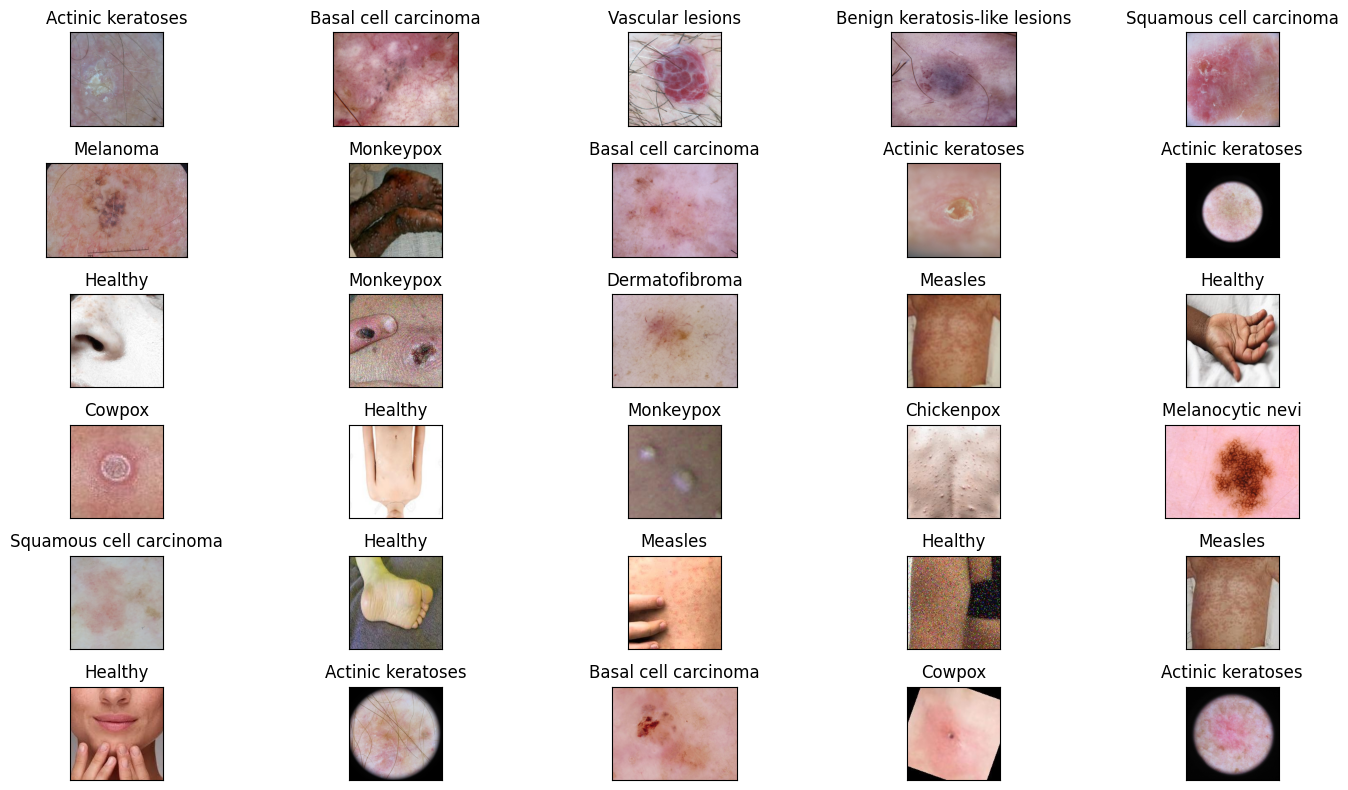

In [16]:
show_images_from_df(df_test, 6, 5)

In [19]:
def preprocess_images(df):
    images = []
    labels = []
    for index, row in df.iterrows():
        img = tf.keras.utils.load_img(row['Path'], target_size=(224, 224))
        img_array = tf.keras.utils.img_to_array(img)/255.0
        img_array = img_array.reshape(224, -1)
        images.append(img_array)
        labels.append(row['Label'])
    return np.array(images), np.array(labels)

In [20]:
train_images, train_labels = preprocess_images(df_train)
val_images, val_labels = preprocess_images(df_val)
test_images, test_labels = preprocess_images(df_test)

In [23]:
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
val_labels = label_encoder.transform(val_labels)
test_labels = label_encoder.transform(test_labels)

In [26]:
train_labels = to_categorical(train_labels, len(CATEGORY_DIRECTORIES))
val_labels = to_categorical(val_labels, len(CATEGORY_DIRECTORIES))
test_labels = to_categorical(test_labels, len(CATEGORY_DIRECTORIES))

## Model Based on Random Values

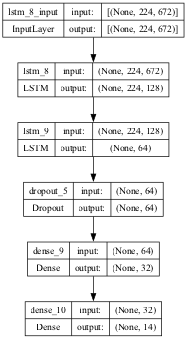

In [45]:
model = Sequential()

model.add(LSTM(units=128, return_sequences=True, input_shape=(224, 224 * 3)))
model.add(LSTM(units=64))
model.add(Dropout(0.3))
model.add(Dense(32, activation="relu"))
model.add(Dense(len(CATEGORY_DIRECTORIES), activation="softmax"))

tf.keras.utils.plot_model(model, f"{RNN_IMAGE_RESULTS}/lstm_model_summary.png", show_shapes=True, dpi=50)

In [46]:
model.compile(
    optimizer = Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=20,
    mode="min",
    restore_best_weights=True,
    verbose=1
)

In [47]:
# Get history
history = model.fit(train_images, train_labels, validation_data=(val_images, val_labels),
                    batch_size=32, epochs=100, callbacks=[early_stopping])

Epoch 1/100


2025-01-25 18:25:08.002027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-25 18:25:08.177979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-25 18:25:08.258591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-25 18:25:08.399048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/342 [..............................] - ETA: 13:27 - loss: 2.6391 - categorical_accuracy: 0.0938

2025-01-25 18:25:08.742848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


342/342 [==============================] - ETA: 0s - loss: 2.6162 - categorical_accuracy: 0.0852

2025-01-25 18:25:23.107508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-25 18:25:23.182513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-25 18:25:23.228036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


342/342 [==============================] - 17s 44ms/step - loss: 2.6162 - categorical_accuracy: 0.0852 - val_loss: 2.6822 - val_categorical_accuracy: 0.0357
Epoch 2/100
342/342 [==============================] - 13s 37ms/step - loss: 2.5871 - categorical_accuracy: 0.0881 - val_loss: 2.6626 - val_categorical_accuracy: 0.0603
Epoch 3/100
342/342 [==============================] - 12s 36ms/step - loss: 2.5729 - categorical_accuracy: 0.0882 - val_loss: 2.6530 - val_categorical_accuracy: 0.0637
Epoch 4/100
342/342 [==============================] - 12s 36ms/step - loss: 2.5656 - categorical_accuracy: 0.0871 - val_loss: 2.6480 - val_categorical_accuracy: 0.0671
Epoch 5/100
342/342 [==============================] - 12s 36ms/step - loss: 2.5617 - categorical_accuracy: 0.0851 - val_loss: 2.6451 - val_categorical_accuracy: 0.0637
Epoch 6/100
342/342 [==============================] - 12s 36ms/step - loss: 2.5595 - categorical_accuracy: 0.0884 - val_loss: 2.6435 - val_categorical_accuracy: 0.062

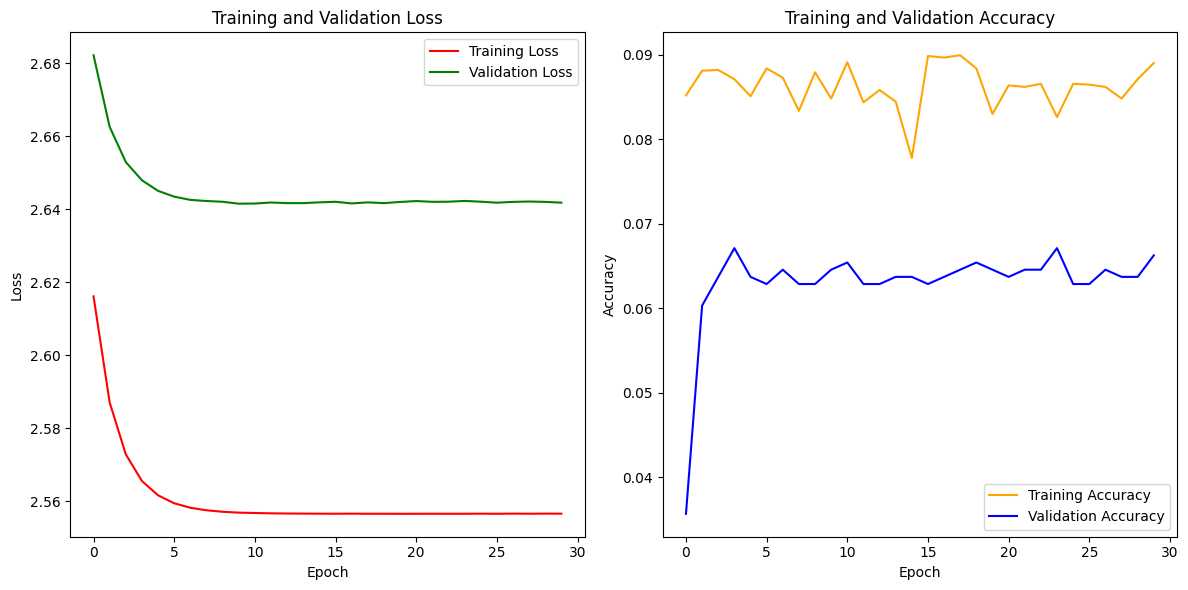

In [48]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'red', label='Training Loss')
plt.plot(history.history['val_loss'], 'green', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], 'orange', label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], 'blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()

plt.savefig(f"{RNN_IMAGE_RESULTS}/lstm_training_plots.png")
history_df = pd.DataFrame(history.history)
history_csv = f"{RNN_HISTORY_RESULTS}/lstm_history.csv"
history_df.to_csv(history_csv)

In [54]:
y_pred = model.predict(test_images)

y_true = np.argmax(test_labels, axis=1)
y_pred = np.argmax(y_pred, axis=1)

38/38 [==============================] - 1s 13ms/step


In [55]:
report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)
print("Classification Report:\n", report)

report_file = f"{RNN_REPORT_RESULTS}/lstm_classification_report.txt"
with open(report_file, 'w') as file:
    file.write(report)

Classification Report:
                                precision    recall  f1-score   support

            Actinic keratoses       0.00      0.00      0.00        88
         Basal cell carcinoma       0.10      0.79      0.18       100
Benign keratosis-like lesions       0.01      0.01      0.01       100
                   Chickenpox       0.00      0.00      0.00       100
                       Cowpox       0.00      0.00      0.00        99
               Dermatofibroma       0.00      0.00      0.00        25
                         HFMD       0.00      0.00      0.00       100
                      Healthy       0.33      0.01      0.02       100
                      Measles       0.00      0.00      0.00        83
             Melanocytic nevi       0.00      0.00      0.00       100
                     Melanoma       0.06      0.17      0.09       100
                    Monkeypox       0.21      0.04      0.07       100
      Squamous cell carcinoma       0.00      0.00  

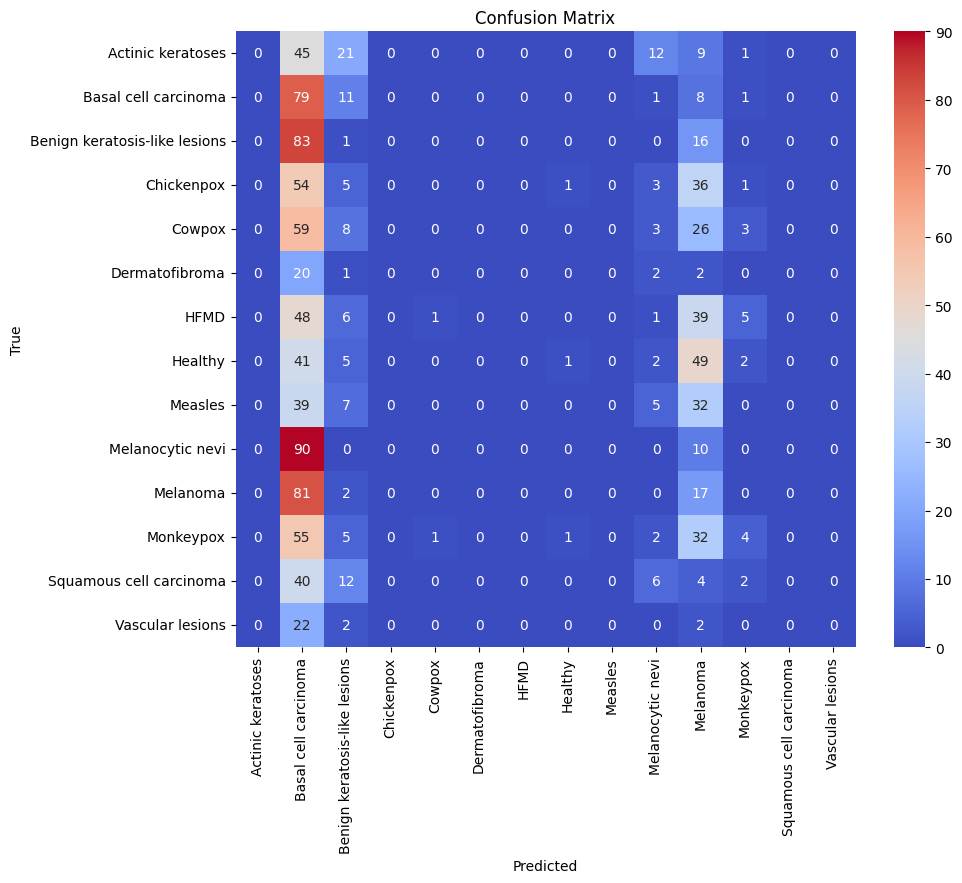

In [57]:
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

heatmap_file = f'{RNN_IMAGE_RESULTS}/lstm_confusion_matrix.png'
plt.savefig(heatmap_file)

In [58]:
model.save(f"{RNN_MODEL_RESULTS}/lstm.h5")

## Hyper-parameter Tuned Model

In [ ]:
def build_model_lstm(hp):
    model = Sequential()

    model.add(LSTM(units=hp.Int('units_lstm_1', min_value=64, max_value=256, step=64),
    input_shape=(224, 224 * 3),
    return_sequences=True))

    model.add(LSTM(units=hp.Int('units_lstm_2', min_value=32, max_value=128, step=32)))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units_dense', min_value=16, max_value=64, step=16), activation='relu'))
    model.add(Dense(len(CATEGORY_DIRECTORIES), activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'])

    return model

In [ ]:
stop_early=EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min', restore_best_weights=True)

In [ ]:
tuner = RandomSearch(
        build_model_lstm,
        objective="val_categorical_accuracy",
        max_trials=5
        executions_per_trial=1,
        directory="hyperparameter_tuning",
        project_name='LSTM'
    )

tuner.search(train_images, train_labels, validation_data=(val_images, val_labels), epochs=20, callbacks=[stop_early])
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    
print(f"""
Best hyperparameters:
- Units in LSTM Layer 1: {best_hps.get('units_lstm_1')}
- Units in LSTM Layer 2: {best_hps.get('units_lstm_2')}
- Dropout Rate: {best_hps.get('dropout_rate')}
- Units in Dense Layer 1: {best_hps.get('units_dense')}
- Learning Rate: {best_hps.get('learning_rate')}
""")

In [ ]:
model = tuner.hypermodel.build(best_hps)

tf.keras.utils.plot_model(model, f"{RNN_IMAGE_RESULTS}/lstm_model_hp_summary.png", show_shapes=True, dpi=50)

In [ ]:
history = model.fit(train_images, train_labels, validation_data=(val_images, val_labels),
                    batch_size=32, epochs=100, callbacks=[stop_early])

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'red', label='Training Loss')
plt.plot(history.history['val_loss'], 'green', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], 'orange', label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], 'blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()

plt.savefig(f"{RNN_IMAGE_RESULTS}/lstm_training_hp_plots.png")
history_df = pd.DataFrame(history.history)
history_csv = f"{RNN_HISTORY_RESULTS}/lstm_hp_history.csv"
history_df.to_csv(history_csv)

In [ ]:
y_pred = model.predict(test_images)

y_true = np.argmax(test_labels, axis=1)
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)
print("Classification Report:\n", report)

report_file = f"{RNN_REPORT_RESULTS}/lstm_hp_classification_report.txt"
with open(report_file, 'w') as file:
    file.write(report)

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

heatmap_file = f'{RNN_IMAGE_RESULTS}/lstm_hp_confusion_matrix.png'
plt.savefig(heatmap_file)